In [16]:
""" This is Phase 1 project Movie Data Exploration File started on 6 May 2023"""
""" FIVE DATASETS: 
1. SQL - MOVIE DATA, im.db
2. CSV - movie grosses, bom.movie_gross.csv
3. TSV - movie info, rt.movie_info.tsv
4. CSV - MOVIE BUDGETS, movie_budgets.csv
5. TSV - reviews, rt.reviews.tsv
6. CSV - movies, movies.csv"""

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import os
import zlib
import zipfile
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path  
import glob


In [17]:
#This is a function to find the number of missing values per column in a dataframe
def missing_values(df_name):
    """This function iterates to find the number of missing values per column"""
    print ("Missing values by Column")
    for col in df_name.columns:
        missing = df_name[col].isna().sum()
        print (str(col) + ": " + str(missing) + " missing values")
    return

In [18]:
# This is a function to create a table of Value Counts for a particular column
def column_value_counts(df_name, col_name):
    list1 = []
    list_dict = {}
    for index, row in df_name.iterrows():
        value = row[col_name]
        if value in list1:
            list_dict[col_name] +=1
            continue
        else:
            list1.append(value)
            list_dict[col_name] = 1

    print("There are " + str(len(list1)) + " unique.")
    return

In [19]:
# 1) SQL - MOVIE DATA  

# Extract SQL db from zip
# ZipFile.extractall(file_path , members=None, pwd=None)Home\MovieData\


#textFile = zipfile.ZipFile("/home/hatenotwelcome/MovieData/im.db.zip", "r")
#textFile.close()

#SQL DB includes 8 tables: principals, known-for, directors, writers, persons, movie_basics, movie_ratings, movie_akas
# principals: *movie_id, 

conn = sqlite3.Connection("/home/bringingthesparkle/FlatIron/Movie_Data/im.db")

q = """
SELECT *
FROM principals
LIMIT 5
;
"""

pd.read_sql(q, conn)

# Connection closed at bottome of file

OperationalError: unable to open database file

In [ ]:
# 2) MOVIE GROSSES

#This is the CSV containing  movie names and their domestic grosses and foreign grosses
# In this table, title has no missing values, but not sure if all unique, adding an index might be necessary
movie_grosses = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/bom.movie_gross.csv.gz', sep=',')

print(movie_grosses.dtypes)
print(movie_grosses.tail(5))
print('\n')

missing_values(movie_grosses)


title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object
                            title      studio  domestic_gross foreign_gross   
3382                    The Quake       Magn.          6200.0           NaN  \
3383  Edward II (2018 re-release)          FM          4800.0           NaN   
3384                     El Pacto        Sony          2500.0           NaN   
3385                     The Swan  Synergetic          2400.0           NaN   
3386            An Actor Prepares       Grav.          1700.0           NaN   

      year  
3382  2018  
3383  2018  
3384  2018  
3385  2018  
3386  2018  


Missing values by Column
title: 0 missing values
studio: 5 missing values
domestic_gross: 28 missing values
foreign_gross: 1350 missing values
year: 0 missing values


In [ ]:
# creating new dataframe to represent only those with domestic gross, removing rows without
movie_grosses_domestic = movie_grosses.dropna(subset=['domestic_gross'])
# The initial shape had 3387 rows and 28 less is 3359
print (len(movie_grosses_domestic))
                                        
# then split/apply/combine on studio
studios = []
studios_dict = {}




column_value_counts(movie_grosses_domestic, 'studio')

#for index, row in movie_grosses_domestic.iterrows():
#    studio = row['studio']
#    if studio in studios:
#        studios_dict[studio] +=1
#        continue
#    else:
#        studios.append(studio)
#        studios_dict[studio] = 1

#print("There are " + str(len(studios)) + " unique studios.")
#print (studios)

df = pd.DataFrame(studios_dict.items(), columns=["Studio", "Studio_Count"])
print (df.sort_values(by=['Studio_Count'], ascending = False))



3359
There are 256 unique.
Empty DataFrame
Columns: [Studio, Studio_Count]
Index: []


In [ ]:
# replace NaNS with Unknowns
movie_grosses = movie_grosses.replace(np.nan, 'Unknown')

for col in movie_grosses.columns:
    assert movie_grosses[col].isna().sum() == 0

print(movie_grosses.shape)

(3387, 5)


In [ ]:
#3) CSV - MOVIE INFO

# This is the CSV with movie information with columns: id, synopsis, rating, genre, director, writer, theater_date, dvd_date, currency, box_office, runtime, studio.
# ID has type int64, all others are mixed type objects and may need cleaning. 
movie_info = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/rt.movie_info.tsv', sep='\t')
print(movie_info.head(2))

#print(movie_info.dtypes)
#print(movie_info.shape) # Shape is (1560 by 12)

# Assert that 'id' is a unique record and there are no missing values
assert movie_info["id"].isna().sum() == 0

#Using missing values function to count NaNs per column
missing_values(movie_info)


   id                                           synopsis rating   
0   1  This gritty, fast-paced, and innovative police...      R  \
1   3  New York City, not-too-distant-future: Eric Pa...      R   

                                 genre          director   
0  Action and Adventure|Classics|Drama  William Friedkin  \
1    Drama|Science Fiction and Fantasy  David Cronenberg   

                         writer  theater_date      dvd_date currency   
0                Ernest Tidyman   Oct 9, 1971  Sep 25, 2001      NaN  \
1  David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   

  box_office      runtime             studio  
0        NaN  104 minutes                NaN  
1    600,000  108 minutes  Entertainment One  
Missing values by Column
id: 0 missing values
synopsis: 62 missing values
rating: 3 missing values
genre: 8 missing values
director: 199 missing values
writer: 449 missing values
theater_date: 359 missing values
dvd_date: 359 missing values
currency: 1220 mis

In [ ]:
# Make a heat map of most frequent words.  Might need to 

In [ ]:
# Replacing NaNs and asserting that none remain

movie_info = movie_info.replace(np.nan, 'Unknown')

for col in movie_info.columns:
    assert movie_info[col].isna().sum() == 0

In [ ]:
movie_info["genre"].value_counts().nlargest(10)
# Clearly the genre column contains more than one category and would be best if separated into dictionaries where you can query on the key

genre
Drama                                              151
Comedy                                             110
Comedy|Drama                                        80
Drama|Mystery and Suspense                          67
Art House and International|Drama                   62
Action and Adventure|Drama                          42
Action and Adventure|Drama|Mystery and Suspense     40
Drama|Romance                                       35
Comedy|Romance                                      32
Art House and International|Comedy|Drama            31
Name: count, dtype: int64

In [ ]:
# Massage the data 

# Create a list of all genres to query on.
movie_genres = []
movie_genre_dict = {}

for index, row in movie_info.iterrows():
    massage = row['genre']
    data = massage.split("|")
    #print (data)
    for word in data:
        if word in movie_genres:
            movie_genre_dict[word] +=1
        else:
            movie_genres.append(word)
            movie_genre_dict[word] = 1

    

print("There are " + str(len(movie_genres)) + " unique genres.")
print (movie_genres)

df = pd.DataFrame(movie_genre_dict.items(), columns=["Genre", "Genre_Counts"])
print (df.sort_values(by=['Genre_Counts'], ascending = False))


There are 22 unique genres.
['Action and Adventure', 'Classics', 'Drama', 'Science Fiction and Fantasy', 'Musical and Performing Arts', 'Mystery and Suspense', 'Romance', 'Kids and Family', 'Comedy', 'Unknown', 'Documentary', 'Special Interest', 'Art House and International', 'Horror', 'Western', 'Television', 'Sports and Fitness', 'Animation', 'Faith and Spirituality', 'Cult Movies', 'Anime and Manga', 'Gay and Lesbian']
                          Genre  Genre_Counts
2                         Drama           912
8                        Comedy           550
0          Action and Adventure           366
5          Mystery and Suspense           309
12  Art House and International           265
6                       Romance           198
1                      Classics           193
3   Science Fiction and Fantasy           172
13                       Horror           134
7               Kids and Family            99
4   Musical and Performing Arts            98
10                  Do

In [ ]:
# 4) CSV - MOVIE BUDGETS
#This is the file tn.movie_budgets.csv.gz. This is the only file with the budgets and grosses from which you can obtain the ROI.

movie_budgets = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/tn.movie_budgets.csv.gz', sep=',')

print(movie_budgets.dtypes)
print(movie_budgets.tail(5))
print('\n')

missing_values(movie_budgets)  #

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object
      id  release_date                          movie production_budget   
5777  78  Dec 31, 2018                         Red 11            $7,000  \
5778  79   Apr 2, 1999                      Following            $6,000   
5779  80  Jul 13, 2005  Return to the Land of Wonders            $5,000   
5780  81  Sep 29, 2015           A Plague So Pleasant            $1,400   
5781  82   Aug 5, 2005              My Date With Drew            $1,100   

     domestic_gross worldwide_gross  
5777             $0              $0  
5778        $48,482        $240,495  
5779         $1,338          $1,338  
5780             $0              $0  
5781       $181,041        $181,041  


Missing values by Column
id: 0 missing values
release_date: 0 missing values
movie: 0 missing values
production_budget: 0 missing values


In [ ]:
# String cleaning to turn budget and gross figures into numeric values, and compute the ROI.
movie_budgets["production_budget"] = movie_budgets["production_budget"].str.replace("$","").str.replace(",","")
movie_budgets["production_budget"] = pd.to_numeric(movie_budgets["production_budget"])
movie_budgets["domestic_gross"] = movie_budgets["domestic_gross"].str.replace("$","").str.replace(",","")
movie_budgets["domestic_gross"] = pd.to_numeric(movie_budgets["domestic_gross"])
movie_budgets["worldwide_gross"] = movie_budgets["worldwide_gross"].str.replace("$","").str.replace(",","")
movie_budgets["worldwide_gross"] = pd.to_numeric(movie_budgets["worldwide_gross"])
movie_budgets["ROI"] = ((movie_budgets["domestic_gross"] + movie_budgets["worldwide_gross"]) - movie_budgets["production_budget"])
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,876127750
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-157475300
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1531419831
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,1619903129


In [ ]:
#Now that ROI has been calculated, can sort by ROI
movie_budgets.sort_values('ROI', ascending = False, inplace=True)
print(movie_budgets.head())


    id  release_date                                 movie  production_budget   
0    1  Dec 18, 2009                                Avatar          425000000  \
5    6  Dec 18, 2015  Star Wars Ep. VII: The Force Awakens          306000000   
42  43  Dec 19, 1997                               Titanic          200000000   
6    7  Apr 27, 2018                Avengers: Infinity War          300000000   
33  34  Jun 12, 2015                        Jurassic World          215000000   

    domestic_gross  worldwide_gross         ROI  
0        760507625       2776345279  3111852904  
5        936662225       2053311220  2683973445  
42       659363944       2208208395  2667572339  
6        678815482       2048134200  2426949682  
33       652270625       1648854864  2086125489  


In [ ]:
# Calculate percentiles
data = np.array(movie_budgets['ROI'])
print(len(data))
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
print (q75)
print(q25)
top_25_pct = movie_budgets[movie_budgets['ROI']> q75]
print(type(top_25_pct))
bottom_25_pct = movie_budgets[movie_budgets['ROI']< q25 ]
#iqr_range = movie_budgets.loc[[movie_budgets['ROI']> q25] & [movie_budgets['ROI']<q75]]
print(len(top_25_pct))
print(len(bottom_25_pct))
#above_35 = titanic[titanic["Age"] > 35]

5782
111164787.5
-309822.25
<class 'pandas.core.frame.DataFrame'>
1446
1446


{'whiskers': [<matplotlib.lines.Line2D at 0x7f23814dc970>,
 'caps': [<matplotlib.lines.Line2D at 0x7f23814dceb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f23814dc6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f23814dd3f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f23814dd690>],
 'means': []}

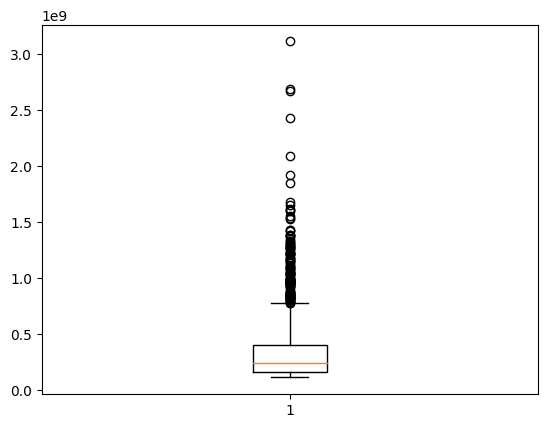

In [ ]:
#boxplot of ROI (later to be updated with the by genre specs)

matplotlib.pyplot.boxplot(top_25_pct['ROI']) # This isn't right
#matplotlib.pyplot.boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, *, data=None)

In [ ]:
# Exploration of Titles

from sklearn.feature_extraction.text import CountVectorizer

vocab_list = top_25_pct['movie']
print(type(vocab_list.to_list()))
coun_vect = CountVectorizer()
coun_vect.fit_transform(vocab_list.to_list())
print ("Vocabulary:")
print((coun_vect.vocabulary_))

#freq_term_matrix = coun_vect.transform(vocab_list)
#print (freq_term_matrix.todense())

#"""train_set = ["The sky is blue.", "My future is bright.", "I have international level problems."]
#test_set = ["The sun in the sky is bright.", "We can see the shining sun, the bright sun."]
#count_vectorizer = CountVectorizer()
#count_vectorizer.fit_transform(train_set) # I like data science and I'd like to really go back to grad school in eng, eng mgmt
#print ("Vocabulary:")
#print(count_vectorizer.vocabulary_)
#Vocab = list(count_vectorizer.vocabulary_)
#print(Vocab)

# Vocabulary: {'blue': 0, 'sun': 1, 'bright': 2, 'sky': 3}
#freq_term_matrix = count_vectorizer.transform(test_set)
#print (freq_term_matrix.todense())

#count_array = freq_term_matrix.toarray()
#df = pd.DataFrame(data=count_array, columns=Vocab)
#print(df)

#from sklearn.feature_extraction.text import TfidfTransformer
#tfidf = TfidfTransformer(norm="l2")
#tfidf.fit(freq_term_matrix)
#print ("IDF:")
#print(tfidf.idf_)"""



<class 'list'>
Vocabulary:
{'avatar': 122, 'star': 1545, 'wars': 1781, 'ep': 535, 'vii': 1753, 'the': 1622, 'force': 619, 'awakens': 128, 'titanic': 1649, 'avengers': 124, 'infinity': 839, 'war': 1776, 'jurassic': 904, 'world': 1829, 'black': 190, 'panther': 1203, 'furious': 646, 'incredibles': 835, 'viii': 1754, 'last': 948, 'jedi': 875, 'beauty': 159, 'and': 75, 'beast': 156, 'harry': 747, 'potter': 1279, 'deathly': 430, 'hallows': 734, 'part': 1210, 'ii': 823, 'fallen': 571, 'kingdom': 922, 'age': 45, 'of': 1165, 'ultron': 1707, 'frozen': 639, 'lord': 995, 'rings': 1369, 'return': 1353, 'king': 921, 'iron': 857, 'man': 1020, 'minions': 1069, 'phantom': 1239, 'menace': 1053, 'rogue': 1385, 'one': 1173, 'story': 1566, 'captain': 268, 'marvel': 1033, 'park': 1209, 'dark': 413, 'knight': 928, 'lion': 981, 'aquaman': 96, 'shrek': 1471, 'finding': 600, 'dory': 477, 'america': 65, 'civil': 320, 'toy': 1669, 'transformers': 1676, 'moon': 1095, 'jumanji': 899, 'welcome': 1796, 'to': 1652, 'j

In [ ]:
#5) TSV - reviews, rt.reviews.tsv
# ratings is in multiple different forms and would need manipulation

movie_info = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/rt.reviews.tsv', sep='\t', encoding='latin1')
print(movie_info.head(5))

print(movie_info.dtypes)
print(movie_info.shape) # Shape is (1560 by 12)

# Assert that 'id' is a unique record and there are no missing values
assert movie_info["id"].isna().sum() == 0

#Using missing values function to count NaNs per column
missing_values(movie_info)

   id                                             review rating   fresh   
0   3  A distinctly gallows take on contemporary fina...    3/5   fresh  \
1   3  It's an allegory in search of a meaning that n...    NaN  rotten   
2   3  ... life lived in a bubble in financial dealin...    NaN   fresh   
3   3  Continuing along a line introduced in last yea...    NaN   fresh   
4   3             ... a perverse twist on neorealism...     NaN   fresh   

           critic  top_critic         publisher               date  
0      PJ Nabarro           0   Patrick Nabarro  November 10, 2018  
1  Annalee Newitz           0           io9.com       May 23, 2018  
2    Sean Axmaker           0  Stream on Demand    January 4, 2018  
3   Daniel Kasman           0              MUBI  November 16, 2017  
4             NaN           0      Cinema Scope   October 12, 2017  
id             int64
review        object
rating        object
fresh         object
critic        object
top_critic     int64
publisher

In [21]:
#6) CSV - movies, tmdb_movies.csv
import pandas as pd

movie_tmdb = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/tmdb.movies.csv', sep=',')

print(movie_tmdb.dtypes)
print(movie_tmdb.tail(5))
print('\n')

# Assert that 'id' is a unique record and there are no missing values
assert movie_tmdb["id"].isna().sum() == 0
 #


Unnamed: 0             int64
genre_ids             object
id                     int64
original_language     object
original_title        object
popularity           float64
release_date          object
title                 object
vote_average         float64
vote_count             int64
dtype: object
       Unnamed: 0        genre_ids      id original_language   
26512       26512         [27, 18]  488143                en  \
26513       26513         [18, 53]  485975                en   
26514       26514     [14, 28, 12]  381231                en   
26515       26515  [10751, 12, 28]  366854                en   
26516       26516         [53, 27]  309885                en   

              original_title  popularity release_date                  title   
26512  Laboratory Conditions         0.6   2018-10-13  Laboratory Conditions  \
26513        _EXHIBIT_84xxx_         0.6   2018-05-01        _EXHIBIT_84xxx_   
26514           The Last One         0.6   2018-10-01           The Las

In [ ]:
# Can get genre ids from API call to tmdb
#https://www.themoviedb.org/settings/api
# see https://www.sololearn.com/compiler-playground/WgZHrhC3dhbh/?ref=app

import json
import requests

term = 'genres'

def get_keys(path):
    with open(path) as f:
        return json.load(f)

keys = get_keys("/home/bringingthesparkle/.secret/tmdb_api.json")

api_key = keys['api_key']

#the api url that contains the dictionary of genre types.
url = "https://api.themoviedb.org/3//genre/movie/list"

headers = {
    "accept": "application/json",
    "Authorization": 'Bearer {}'.format(api_key),
}

url_params = {
                'term': term.replace(" ", "+")
}

response = requests.get(url, headers=headers, params = url_params)

print(response.text)

text_file = open("/home/bringingthesparkle/FlatIron/genre_ids.txt", "w")
n = text_file.write('response.text')
text_file.close()

# using json.loads() method
result = json.loads(response.text)


  


{"genres":[{"id":28,"name":"Action"},{"id":12,"name":"Adventure"},{"id":16,"name":"Animation"},{"id":35,"name":"Comedy"},{"id":80,"name":"Crime"},{"id":99,"name":"Documentary"},{"id":18,"name":"Drama"},{"id":10751,"name":"Family"},{"id":14,"name":"Fantasy"},{"id":36,"name":"History"},{"id":27,"name":"Horror"},{"id":10402,"name":"Music"},{"id":9648,"name":"Mystery"},{"id":10749,"name":"Romance"},{"id":878,"name":"Science Fiction"},{"id":10770,"name":"TV Movie"},{"id":53,"name":"Thriller"},{"id":10752,"name":"War"},{"id":37,"name":"Western"}]}


In [ ]:
#continuing without making another API call
print(result)
genre_list = result['genres']
print(genre_list)



{'genres': [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}, {'id': 99, 'name': 'Documentary'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}, {'id': 36, 'name': 'History'}, {'id': 27, 'name': 'Horror'}, {'id': 10402, 'name': 'Music'}, {'id': 9648, 'name': 'Mystery'}, {'id': 10749, 'name': 'Romance'}, {'id': 878, 'name': 'Science Fiction'}, {'id': 10770, 'name': 'TV Movie'}, {'id': 53, 'name': 'Thriller'}, {'id': 10752, 'name': 'War'}, {'id': 37, 'name': 'Western'}]}
[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}, {'id': 99, 'name': 'Documentary'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}, {'id': 36, 'name': 'History'}, {'id': 27, 'name': 'Horror'}, {'id': 10402, 'name': 'Music'},

In [27]:
#movie_tmdb and genre_ids
movie_genre_ids = []
genre_id_dict = {}

for index, row in movie_tmdb.iterrows():
    massage = row['genre_ids']
    massage = massage.replace("[", "")
    massage = massage.replace("]", "")
    data = massage.split(",")
    #print (data)
    for id in data:
        if id in movie_genre_ids:
            genre_id_dict[id] +=1
        else:
            movie_genre_ids.append(id)
            genre_id_dict[id] = 1

    

print("There are " + str(len(movie_genre_ids)) + " unique genre ids.")
print (movie_genre_ids)

df_id = pd.DataFrame(genre_id_dict.items(), columns=["Genre_id", "Genre_Counts"])
print (df_id.sort_values(by=['Genre_Counts'], ascending = False))

There are 39 unique genre ids.
['12', ' 14', ' 10751', '14', ' 12', ' 16', ' 28', ' 878', '16', ' 35', '28', '10751', '53', '27', ' 80', ' 18', ' 10749', ' 53', '10402', '18', ' 9648', ' 36', '35', '80', '10749', ' 37', ' 27', '10770', '9648', ' 10752', ' 10402', ' 10770', '10752', ' 99', '878', '99', '36', '', '37']
   Genre_id  Genre_Counts
19       18          4923
35       99          4407
22       35          3632
15       18          3380
17       53          2674
37                   2479
13       27          2209
9        35          2020
10       28          1651
16    10749          1627
12       53          1533
26       27          1474
7       878          1190
2     10751          1106
14       80           977
6        28           961
20     9648           950
8        16           917
4        12           855
1        14           822
31    10770           719
24    10749           694
18    10402           678
30    10402           589
34      878           572
5    

In [ ]:
# check for missing values
missing_values(movie_tmdb) 

Missing values by Column
Unnamed: 0: 0 missing values
genre_ids: 0 missing values
id: 0 missing values
original_language: 0 missing values
original_title: 0 missing values
popularity: 0 missing values
release_date: 0 missing values
title: 0 missing values
vote_average: 0 missing values
vote_count: 0 missing values


In [ ]:
# Attempting to inner join movie_budgets df & and on movie title 

In [ ]:

# Gotta close that SQL file connection from earlier
conn.close()